
Pierwsza część kodu dotycząca oczyszczeniu danych znajduje się w pliku 1_EDA.ipynb, w którym zostały obrobione dane do budowy modelu klasyfukacji binarnej. Dane są do pobrania z https://www.kaggle.com/c/tabular-playground-series-mar-2021/data

In [1]:
import pandas as pd
import numpy as np
import os 

data_path = r"E:\page_ds\overestimating_features"
X = pd.read_csv(os.path.join(data_path, "x_train.csv"))
y = pd.read_csv(os.path.join(data_path, "y_train.csv"))



Accuracy for validation set: 0.8416
Accuracy for train set: 0.9247
Wartość parametru Gini na zbiorze walidacyjnym to: 0.7569
Wartość parametru Gini na zbiorze treningowym to: 0.9417

ROC Curve

Confusion Matrix


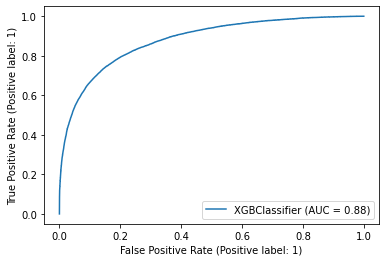

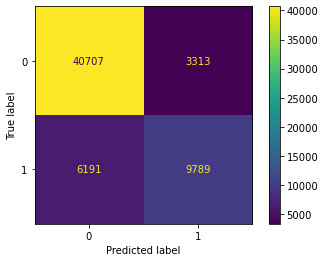

In [2]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score # dane są nisko niezbalansowane przez co powinniśmy rozpatrzyć losowanie warstwowe
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

# dzielimy nasz zbiór na treningowy oraz testowy. Poza tym pamiętajmy, że mamy do dyspozycji zbiór walidacyjny około 200k rekordów
# ponieważ wybór proporcji próbki na uczącą i walidacyjną może wpłynąć na jakość modelu, powinniśmy rozważyć wrzucenie tego 
# parametru jako elementu optymalizacji hiperparametrów

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=128262)

    
# inicjalizujemy model 
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            booster="gbtree",
                            reg_lambda = 0.451065801218468,
                            alpha=0.6902857337758832,
                            max_depth=9,
                            eta=0.40371759686544195,
                            gamma=2.542658350556566e-08,
                            grow_policy="lossguide",
                           # sample_type="weighted",
                           #normalize_type="forest",
                            #rate_drop=3.3165167625838494e-07,
                            #skip_drop=0.0003657525314966573
                            )

    
# uczymy model, korzystamy z API sklearn
xgb_clf.fit(X_train, y_train)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar

y_hat = xgb_clf.predict(X_test)

auc_val = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
auc_train = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])

print("Accuracy for validation set: {0:.4f}".format(accuracy_score(y_test, y_hat)))
print("Accuracy for train set: {0:.4f}".format(accuracy_score(y_train, xgb_clf.predict(X_train))))

print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train-1)) # Gini = 2*AUC-1

print("\nROC Curve")
print(RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test))

print("\nConfusion Matrix")
#print(plot_confusion_matrix(xgb_clf, X_test, y_test))
cm = confusion_matrix(y_test, y_hat, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
print(disp.plot())
plt.show()

Jak widać mamy do czynienia ze zbyt mocnym dopasowaniem modelu do zbioru treningowego: moc istotnie spada po przejściu na zbiór walidacyjny. Przeliczmy zatem wartości współczynników Shapley'a na zbiorze treningowym oraz walidacyjnym  
https://krzysztofzdanowicz.com/2022/10/model_explainability/


In [4]:
import xgboost as xgb
import shap

booster_xgb = xgb_clf.get_booster()

# wartości Shapley'a dla zbioru treningowego
shap_values_train = booster_xgb.predict(xgb.DMatrix(X_train, y_train),
                                      pred_contribs=True)

shap_values_train = shap_values_train[:, :-1]

# i to samo dla zbioru testowego
shap_values_test = booster_xgb.predict(xgb.DMatrix(X_test, y_test),
                                      pred_contribs=True)

shap_values_test = shap_values_test[:, :-1]

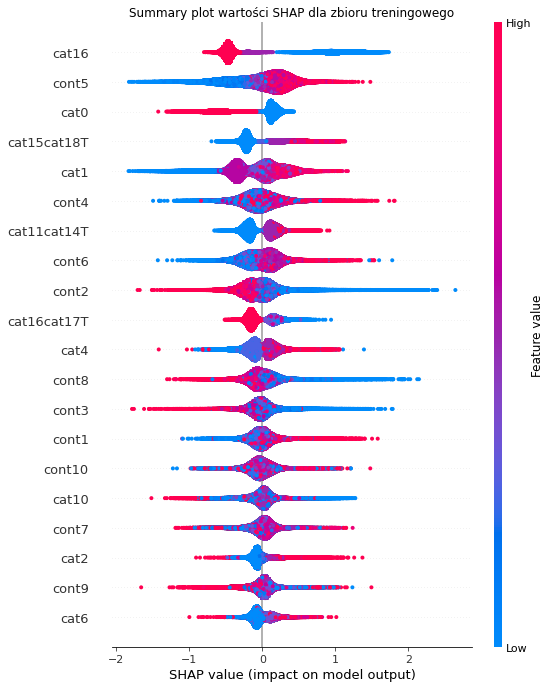

In [56]:
path_pict = r"E:\page_ds\overestimating_features\foto"
f = plt.figure()
shap.summary_plot(shap_values_train, X_train, feature_names=X_train.columns, show=False);
plt.title('Summary plot wartości SHAP dla zbioru treningowego')
f.savefig(os.path.join(path_pict, '2_xgb_summary_train.png'),  format='png', dpi=600 , facecolor='White')


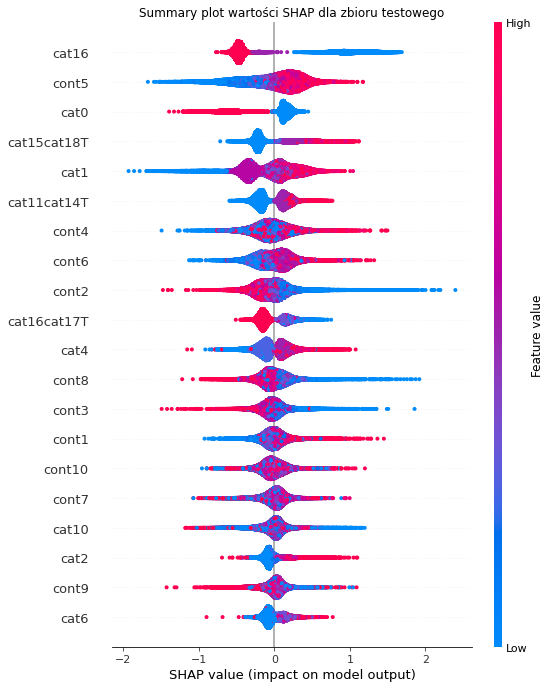

In [57]:
f = plt.figure()
shap.summary_plot(shap_values_test, X_test, feature_names=X_test.columns, show=False);
plt.title('Summary plot wartości SHAP dla zbioru testowego')
f.savefig(os.path.join(path_pict, '2_xgb_summary_test.png'),  format='png', dpi=600 , facecolor='White')

Przeliczamy teraz korelację cząstkąwą 
https://pingouin-stats.org/generated/pingouin.partial_corr.html


In [23]:
from pingouin import partial_corr # pip install pingouin
import matplotlib.pyplot as plt

# tworzę ramki danych z wartościami Shapley'a dla poszczególnych rekordów
shap_train = pd.DataFrame(
    data = shap_values_train,
    index = X_train.index, 
    columns = X_train.columns
)

shap_test = pd.DataFrame(
    data = shap_values_test, 
    index = X_test.index, 
    columns = X_test.columns
)

# Definiuję funkcję do wyliczania korelacji cząstkowej pomiędzy wszystkimi zmiennymi
def partial_correlation(X, y):
    out = pd.Series(index = X.columns, dtype = float)
    for feature_name in X.columns:
        out[feature_name] = partial_corr(
        data = pd.concat([X, y], axis = 1).astype(float), 
        x = feature_name, 
        y = list(y_test.columns)[0],
        x_covar = [f for f in X.columns if f != feature_name] 
        ).loc['pearson', 'r']
    return out


In [24]:
# Przeliczenie korelacji cząstkowej 
parshap_train = partial_correlation(shap_train, y_train)
parshap_test = partial_correlation(shap_test, y_test)
parshap_diff = pd.Series(parshap_test - parshap_train, name = 'parshap_diff')

divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide
divide by zero encountered in true_divide
invali

Wywaliło bardzo dużo błędów i jak się im przyglądnąć to wychodzą one na kolumnach uznanych przez model za nieistotne dlatego w brutalny sposób wywalam je z dalszego analizowania pamiętając o tym, że nie można ich również pokazywać w zestawie danych do wykresów

In [40]:
parshap_train.dropna(inplace=True)
parshap_test.dropna(inplace=True)
parshap_diff = pd.Series(parshap_test - parshap_train, name = 'parshap_diff')

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


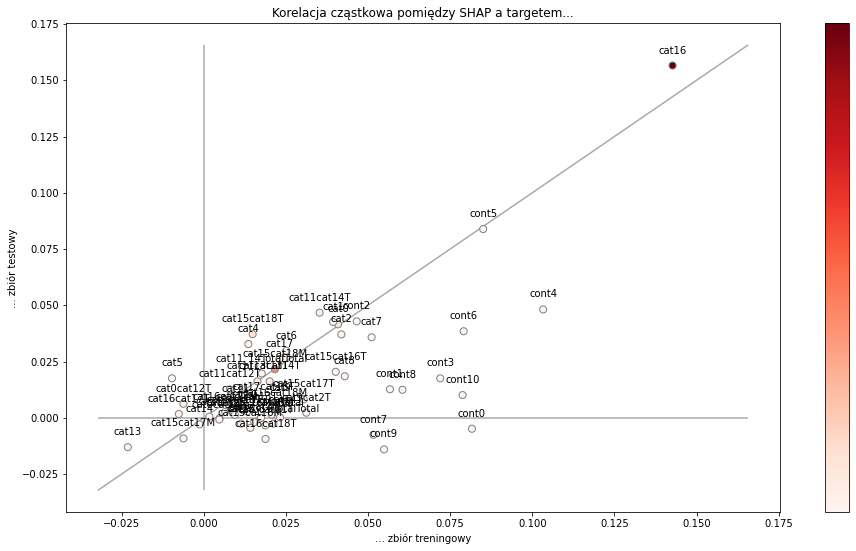

In [59]:
# Wykres zależności pomiędzy korelacjami cząstkowymi zmiennych na zbiorze testowym a walidacyjnym 

# najpierw feature importances dla modelu, należy usunąć nieistotne wartości
fimpo =  pd.Series(xgb_clf.feature_importances_, index = X_train.columns)
fimpo =fimpo[list(parshap_train.index)]

plotmin, plotmax = min(parshap_train.min(), parshap_test.min()), max(parshap_train.max(), parshap_test.max())
plotbuffer = .05 * (plotmax - plotmin)
fig, ax = plt.subplots(figsize=(16, 9))
if plotmin < 0:
    ax.vlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color = 'darkgrey', zorder = 0)
    ax.hlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color = 'darkgrey', zorder = 0)
ax.plot(
    [plotmin - plotbuffer, plotmax + plotbuffer], [plotmin - plotbuffer, plotmax + plotbuffer], 
    color = 'darkgrey', zorder = 0
)
sc = ax.scatter(
    parshap_train, parshap_test, 
    edgecolor = 'grey', c = fimpo, s = 50, cmap = plt.cm.get_cmap('Reds'), vmin = 0, vmax = fimpo.max())
ax.set(title = 'Korelacja cząstkowa pomiędzy SHAP a targetem...', xlabel = '... zbiór treningowy', ylabel = '... zbiór testowy')
cbar = fig.colorbar(sc)
cbar.set_ticks([])
for txt in parshap_train.index:
    ax.annotate(txt, (parshap_train[txt], parshap_test[txt] + plotbuffer / 2), ha = 'center', va = 'bottom')
fig.savefig(os.path.join(path_pict, '3_partialShap.png'), dpi = 600, bbox_inches='tight', facecolor='White')
fig.show()

cont0                 0.002366
cont1                 0.003362
cont2                 0.003513
cont3                 0.002686
cont4                 0.003062
cont5                 0.005319
cont6                 0.003405
cont7                 0.002388
cont8                 0.002764
cont9                 0.002444
cont10                0.002543
cat0                  0.049329
cat1                  0.005411
cat2                  0.005287
cat3                  0.002197
cat4                  0.007677
cat5                  0.003116
cat6                  0.003271
cat7                  0.002890
cat8                  0.002965
cat9                  0.003165
cat10                 0.002873
cat11                 0.005247
cat12                 0.002735
cat13                 0.012180
cat14                 0.001557
cat15                 0.003097
cat16                 0.461102
cat17                 0.005545
cat18                 0.002361
cat9cat2T             0.002868
cat9cat2M             0.002751
cat15cat